In [95]:
def spatial_decomposition(X, unit_cell, *args):
    '''
    % decomposite the spatial domain into cells D with vertices V,
    %
    % Output
    %  V - list of vertices
    %  F - list of faces
    %  I_FD - incidence matrix between faces to cells

    % compute voronoi decomposition
    % V - list of vertices of the Voronoi cells
    % D   - cell array of Vornoi cells with centers X_D ordered accordingly
    '''
    # Imports
    import getopt
    from numpy import cumsum, zeros, unique, sort
    from spatialDecompFunctions import generateUnitCells
    from scipy.spatial import Voronoi
    from scipy.sparse import csr_matrix, coo_array
    from orix.utilities.utilities import uniquerows

    if unit_cell.all() == None:
        unit_cell = calcUnitCell(X)

    if args[0] == 'unit_cell':

        # compute the vertices
        [V, faces] = generateUnitCells(X, unit_cell, args[:])
        # NOTE: V and faces do not give exact values as compared to the MATLAB
        # implementation. However, Eric and Rohan have confirmed that V and faces
        # at least have the same shape as the MATLAB implementation.

        D = np.empty(len(X),dtype=object)

        for k in range(X.shape[0]):
            D[k] = faces[k, :]

    else:    
        var_arg_in = args[0]
        dummy_coordinates = calcBoundary(X, unit_cell, var_arg_in)

        vor = Voronoi(np.vstack([X, dummy_coordinates]), 
                        qhull_options = 'Q5 Q6 Qs') #,'QbB'

        V = vor.vertices
        D = vor.regions
        D = D[0:X.shape[0]]

    # now we need some adjacencies and incidences
    iv = np.hstack(D)        # nodes incident to cells D
    iid = zeros(len(iv), dtype=np.int64)   # number the cells

    # Some MATLAB stuff goin on here... : p = [0; cumsum(cellfun('prodofsize',D))];
    D_prod = matlab_prod_of_size(D)
    p = np.hstack([0, np.cumsum(D_prod)-1])

    # original matlab: for k=1:numel(D), id(p(k)+1:p(k+1)) = k; end
    for k in range(len(D)):
        iid[p[k]+1 : p[k+1]] = k

    # next vertex
    # indx = 2:numel(iv)+1;
    ind_x = np.arange(1,len(iv)+1)
    # indx(p(2:end)) = p(1:end-1)+1;
    ind_x[p[1:]] = p[0:-1] + 1
    # ivn = iv(indx);
    iv_n = iv[ind_x]

    # edges list
    F = np.vstack([iv[:], iv_n[:]]).T

    # should be unique (i.e one edge is incident to two cells D)
    F, _, ie = uniquerows(F)

    # faces incident to cells, F x D
    #original matlab: I_FD = sparse(ie,id,1); 
    # Matlab stores as csr matrix, so we use this class below
    data = np.ones(np.shape(ie))
    I_FD = csr_matrix( (data, (ie, iid)))
    #I_FD = csr_matrix( (data, (ie, iid)), shape=[ie.shape[0], ie.shape[0]]) # could also use csc_matrix() if it improves
                                # performance !
    '''
    NOTE: may need to use different sparse matrix. The matrix is incorrect as
          compared to the MATLAB implementation.
          
          Could also be causing problems in the Householder matrix initialization.
    '''
    

    return V, F, I_FD

def calcBoundary(X, unit_cell, var_arg_in='hull'):
    '''
    dummy coordinates so that the voronoi-cells of X are finite

    Inputs:
    --------------
    X : n x 2 numpy array of [x,y] vertex coordinates

    unit_cell : n x 2 numpy array of [x,y] coordinates of "pixel" boundary (e.g. hexagon or square)

    var_arg_in : ???
    ???


    Outputs:
    --------------
    ??? : ???
    ???

    Dependencies:
    --------------
    import getopt
    import numpy as np
    from scipy.spatial import ConvexHull
    from numpy import arctan2, diff, cumsum, matrix, squeeze, unique
    from statistics import mean
    from math import sqrt, floor, copysign
    '''
    # Imports
    import getopt
    import numpy as np
    from scipy.spatial import ConvexHull
    from numpy import arctan2, cumsum, matrix, squeeze, unique, linspace
    from statistics import mean
    from math import sqrt, floor, copysign
    from orix.quaternion.rotation import Rotation
    import orix.vector as vect
    from orix.utilities.utilities import uniquerows
    
    from spatialDecompFunctions import householderMatrix, translationMatrix#, erase_linearly_dependent_points

    dummy_coordinates = []

    boundary = 'hull'
    boundary = str(var_arg_in)

    if boundary.isalpha():

        if (boundary.lower() == 'hull' or
            boundary.lower() == 'convexhull'):
            
            bounding_X  = erase_linearly_dependent_points(X)
            
            import matplotlib.pyplot as plt
            plt.figure()
            plt.plot(bounding_X[:,0], bounding_X[:,1])
            plt.show()
            
        elif boundary.lower() == 'cube':
            # set up a rectangular box
            envelope_X = [np.amin(X), np.amax(X)]
            bounding_X = [
                envelope_X[1], envelope_X[3],
                envelope_X[2], envelope_X[3],
                envelope_X[2], envelope_X[4],
                envelope_X[1], envelope_X[4],
                envelope_X[1], envelope_X[3],
                ]

        else:
            raise ValueError('Unknown boundary type. Available options are \
            ''hull'', ''convexhull'' and ''cube''.')

    elif isinstance(boundary, float):
        bounding_X = boundary
    
    radius = np.mean(np.sqrt(np.sum( (unit_cell**2), axis=1)))
    
    edge_length = ((matlabdiff(bounding_X)**2).sum(axis=1, keepdims=True))**0.5 
    #edgeLength = sqrt(sum(diff(boundingX).^2,2));
    
    # fill each line segment with nodes every 20 points (in average)
    nto = np.int32(np.fix( (edge_length>0)*4 ))

    print(nto)
    
    #nto = floor( edge_length*(2*radius) )
    #nto = fix((edgeLength>0)*4); fix(edgeLength*(2*radius));

    csum = np.int32(cumsum(np.vstack([0, nto])))
    print(csum)

    bounding_X = left_hand_assignment(bounding_X, csum)

    #print(nto)
    #print(bounding_X)
    #print(csum)
    # interpolation
    for k in range(nto.shape[0]):          # 0 to 5
        for dim in range(nto.shape[1]+1):    # 0
            #print(nto[k]+2)
            #print(k, dim)
            #print(bounding_X[csum[k]:csum[k+1], dim])
            #print(csum[k], csum[k+1])
            #print(bounding_X[csum[k], dim], bounding_X[csum[k+1]-1, dim])
            bounding_X[csum[k]:csum[k+1], dim] = linspace(
                bounding_X[csum[k],dim],
                bounding_X[csum[k+1]-1, dim],
                nto[k,0]
            )
            #print(bounding_X[csum[k]:csum[k+1], dim])
    #print(bounding_X)

    print(bounding_X)
    
    # homogeneous coordinates
    X = np.hstack([X, np.ones([X.shape[0],1])])
    bounding_X = np.hstack([bounding_X, np.ones([bounding_X.shape[0],1])])

    
    # direction of the edge
    edge_direction = matlabdiff(bounding_X)
    edge_angle = arctan2( edge_direction[:, 1], edge_direction[:,0] )
    edge_length = np.sqrt( (edge_direction**2).sum(axis = 1, keepdims=True))

    # shift the starting vertex
    r = Rotation.from_axes_angles(vect.Vector3d([0, 0, 1]), edge_angle)
    a = vect.Vector3d([0, radius, 1])
    b_X = np.squeeze(r * a)
    offset_X = np.squeeze(b_X.data) - np.squeeze(bounding_X[0:-1, :])
        
    dummy_coordinates = np.array([[0,0]])
    for k in range(bounding_X.shape[0]-1):

        # mirror the point set X on each edge
        p_X = np.matmul(X,
            -1*( 
                np.matmul(
                    np.matmul(
                        translationMatrix(offset_X[k, :]),
                        householderMatrix(edge_direction[k, :])
                    ), 
                    translationMatrix(offset_X[k, :])
                ).T
            )
        )

        '''
        NOTE FROM ERIC AND ROHAN: We are having problems with getting the proper
        dummy_coordinates. The bounding box only has 2 of 4 lines, we believe
        this is where the problem is. MATLAB is doing bizarre things with the
        element-wise division!!!!! We need to contact somebody about this behavior.
        Python is doing what we expect but it's not the right answer.
        
        UPDATE FROM ERIC: Changing the order of operations in Python gives the same result as Matlab.
        '''

        # distance between original and mirrored point
        dist = np.sqrt(np.sum((X[:,0:-1]-p_X[:,0:-1])**2, axis=1))

        intend_X = 2. * radius * copysign(1, edge_direction[k,0:1])

        # now try to delete unnecessary points
        m = 2
        tmp_X = p_X[dist < m*radius,0:-1]
        while edge_length[k] / tmp_X.shape[0] >= radius/3:

            tmp_X = p_X[dist < m*radius,0:2]

            right = np.matmul(tmp_X - np.tile( bounding_X[k, 0:2]   - intend_X, [np.shape(tmp_X)[0], 1]), edge_direction[k, 0:2].T) < 0
            left  = np.matmul(tmp_X - np.tile( bounding_X[k+1, 0:2] + intend_X, [np.shape(tmp_X)[0], 1]), edge_direction[k, 0:2].T) > 0

            tmp_X = tmp_X[~np.any(np.vstack([right, left]), axis=0), :]

            if m < 2**7:
                m = m*2
            else:
                m = m+10

        if tmp_X.size > 0:
            dummy_coordinates = np.vstack([dummy_coordinates, tmp_X])

    dummy_coordinates, _, _ = uniquerows(dummy_coordinates[1:,:])
    
    return dummy_coordinates

def matlab_prod_of_size(D):
    '''
    Testing:
    test1 = [[1, 2, 3], [1, 2], [1]]
    matlab_prod_of_size(test1)
    '''
    prod_of_size = []
    for elem in D:
        prod_of_size.append(len(elem))
    return prod_of_size

def erase_linearly_dependent_points(X):
    '''
    subfunction to remove linearly dependent points.

    Inputs:
    --------------
    k : ???
        ???

    Outputs:
    --------------
    ??? : ???
        ???

    Dependencies:
    --------------
    from scipy.spatial import ConvexHull
    '''
    from orix.utilities.utilities import regularPoly
    import numpy as np
    from scipy.spatial import ConvexHull
    from orix.utilities.utilities import sortrows
    k = ConvexHull(X)
    hull = k
    k = k.vertices

    # erase all linear dependent points
    angle = np.arctan2(X[k[0:-1],0]-X[k[1:],0],
        X[k[0:-1],1]-X[k[1:],1])
    test = np.abs(np.diff(angle))>np.spacing(1.0)
    k2 = k[np.concatenate([[True], test, [True]])]
    
    # Build the coord set of the convex hull
    # Pad on the end->start connection to close hull
    boundingX = X[k2,:]
    boundingX  = np.vstack([boundingX , boundingX [0,:] ])
 
    # Testing
    import matplotlib.pyplot as plt
    for simplex in hull.simplices:
        plt.plot(X[simplex, 0], X[simplex, 1], 'k-')
        plt.plot(X[hull.vertices,0], X[hull.vertices,1], 'r--', lw=2)

    return boundingX

def left_hand_assignment(X, a):
    '''
    Attempts to replicate MATLAB left-hand assignment for a 2D array.
 

    Inputs:
    --------------
    X : 2D numpy array
 

    Outputs:
    --------------
    X : 2D numpy array
        This is different from the X passed in, it will return a larger array with
        more zeros.
 
    Dependencies:
    --------------
    import numpy as np
    '''
 
    import numpy as np
    import warnings
    
    if a.dtype != 'int':
        warnings.warn('parameter ''a'' must be of integer type. Converting ''a'' into integers and moving on...')

    a = np.int32(a)
 
    bound_X_init = X
    ncols = X.shape[1]
 
    max_a = np.amax(a)
    bound_X_fin = np.zeros([max_a, ncols])
 
    bound_X_fin[0:bound_X_init.shape[0], :] = bound_X_init
 
    for i, elem in enumerate(a[1:]):
        bound_X_fin[elem-1, :] = bound_X_init[i+1, :]
 
    return bound_X_fin

def matlabdiff(myArray):
    return myArray[1:,:] - myArray[0:-1,:]


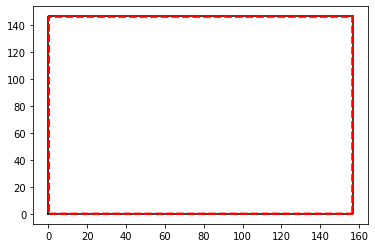

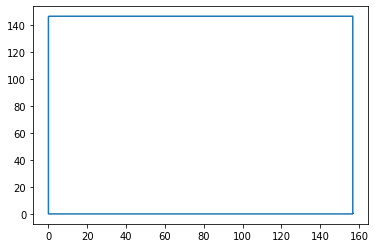

[[4]
 [4]
 [4]
 [4]
 [4]
 [4]]
[ 0  4  8 12 16 20 24]
[[1.56749511e+02 4.33011351e-01]
 [1.56749511e+02 4.92189569e+01]
 [1.56749511e+02 9.80049024e+01]
 [1.56749511e+02 1.46790848e+02]
 [0.00000000e+00 0.00000000e+00]
 [8.33330734e-02 4.89302827e+01]
 [1.66666147e-01 9.78605653e+01]
 [2.49999220e-01 1.46790848e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.87859455e+01]
 [0.00000000e+00 9.75718911e+01]
 [0.00000000e+00 1.46357837e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [5.21665039e+01 0.00000000e+00]
 [1.04333008e+02 0.00000000e+00]
 [1.56499512e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [5.22498370e+01 1.44337117e-01]
 [1.04499674e+02 2.88674234e-01]
 [1.56749511e+02 4.33011351e-01]]


/tmp/ipykernel_280231/1406162585.py:359: UserWarning: parameter a must be of integer type. Converting a into integers and moving on...
  warnings.warn('parameter ''a'' must be of integer type. Converting ''a'' into integers and moving on...')
/tmp/ipykernel_280231/1406162585.py:257: RuntimeWarning: divide by zero encountered in true_divide
  while edge_length[k] / tmp_X.shape[0] >= radius/3:
/tmp/ipykernel_280231/1406162585.py:257: RuntimeWarning: invalid value encountered in true_divide
  while edge_length[k] / tmp_X.shape[0] >= radius/3:


In [96]:
args = (['hull'])

import numpy as np
X = np.loadtxt('spatialDecomposition_input_X.csv', delimiter=',', dtype=float)
unit_cell = np.loadtxt('spatialDecomposition_input_unitCell.csv', delimiter=',', dtype=float)

V, F, I_FD = spatial_decomposition(X, unit_cell, *args)

#return V, F, I_FD

In [ ]:
F_out = np.loadtxt('spatialDecomposition_output_F.txt', delimiter=',', dtype=float)
V_out = np.loadtxt('spatialDecomposition_output_V.txt', delimiter=',', dtype=float)

import scipy.io
I_FD_out = scipy.io.loadmat('spatialDecomposition_output_I_FD.mat')
I_FD_out = I_FD_out['I_FD']

print(np.shape(F_out))
print(np.shape(F))
print(np.shape(V_out))
print(np.shape(V))
print(np.shape(I_FD_out))
print(np.shape(I_FD))

In [3]:
radius = np.mean( sum( (unit_cell**2) ** 0.5 ) )
print(radius)
np.mean(np.sqrt(np.sum( (unit_cell**2), axis=1)))

1.077346908144076


0.2886742340053721

In [4]:
# interpolation

for k in range(nto.shape[0]):
    for dim in range(nto.shape[1]):
        #print(nto[k]+2)
        bounding_X[csum[k]:csum[k+1], dim] = linspace(
            bounding_X[csum[k],dim],
            bounding_X[csum[k+1], dim],
            nto[k,dim]+1
        )

NameError: name 'nto' is not defined